In [137]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 세팅
plt.style.use('seaborn-v0_8') 
sns.set(font_scale = 2.5)


import plotly.offline as py # 그래프를 오프라인으로 그리기 위한 모듈
py.init_notebook_mode(connected = True) # 주피터 노트북 모드로 설정

import plotly.graph_objs as go # 그래프를 그리기 위한 모듈
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

# 3. Feature engineering

## 3.1 Fill Null
### 3.1.1 Fill Null in Age using title

In [138]:
# 알파벳만 추출 (정규 표현식 이용)
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [139]:
# 교차 분석표 (데이터 2개 비교)
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [140]:
# Initial 컬럼의 데이터를 5가지로 구분해서 치환
df_train['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace = True)
df_test['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace = True)

In [141]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


<Axes: xlabel='Initial'>

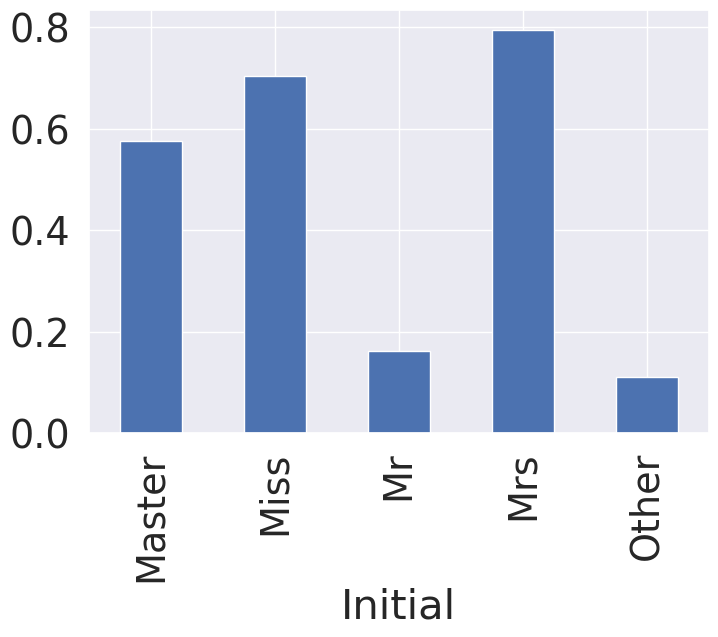

In [142]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [143]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [144]:
# 호칭에 따라 null 값에 age의 평균값으로 채우기
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'), 'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [145]:
# Embarked에 있는 null value의 개수
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


In [146]:
df_train['Embarked'].fillna('S', inplace = True)

## 3.2 Change Age (continuous to categorical)

In [147]:
# 연속형 -> 범주형
# 더 간단한 방법 채택
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

In [148]:
# 원래 컬럼 지우기
df_train.drop(['Age'], axis = 1, inplace = True)
df_test.drop(['Age'], axis = 1, inplace = True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

In [149]:
# Master, Miss, Mr, Mrs, Other 를 수치화
df_train['Initial'] = df_train['Initial'].map({'Master' : 0, 'Miss':1, 'Mr' : 2, 'Mrs' : 3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master' : 0, 'Miss':1, 'Mr' : 2, 'Mrs' : 3, 'Other':4})

In [150]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [151]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [152]:
# C, Q, S 를 수치화
df_train['Embarked'] = df_train['Embarked'].map({'C' : 0, 'Q' : 1, 'S' : 2})
df_test['Embarked'] = df_test['Embarked'].map({'C' : 0, 'Q' : 1, 'S' : 2})

In [153]:
df_train['Embarked'].isnull().any()

False

In [154]:
# female, male 를 수치화
df_train['Sex'] = df_train['Sex'].map({'female' : 0, 'male' : 1})
df_test['Sex'] = df_test['Sex'].map({'female' : 0, 'male' : 1})

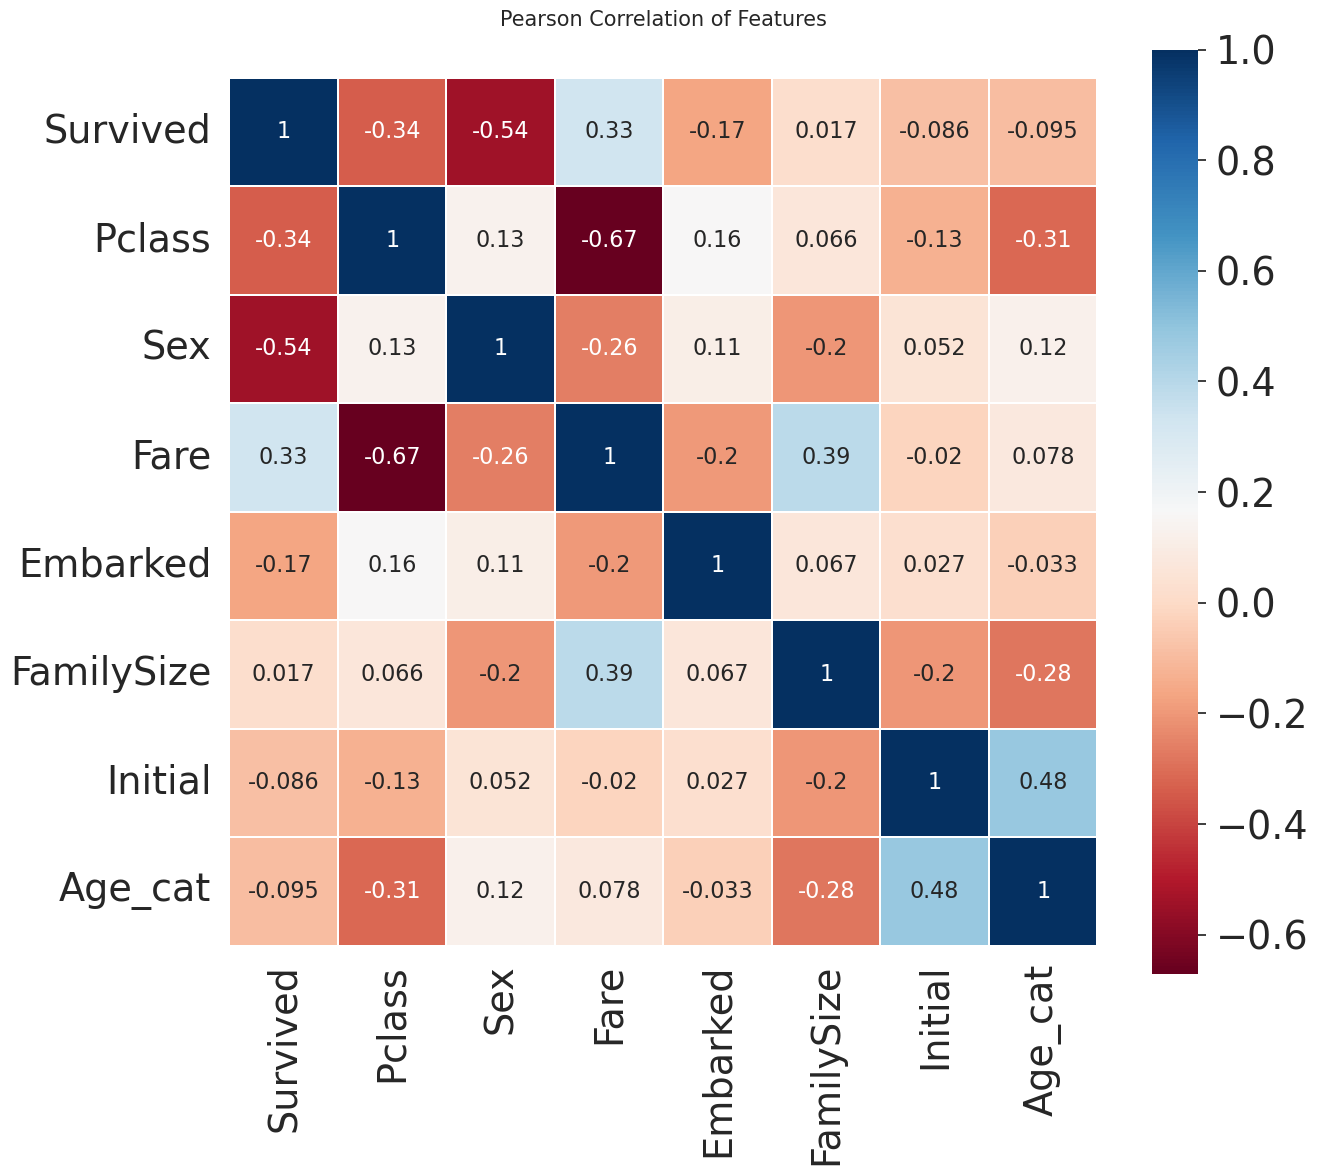

In [155]:
# heatmap 으로 컬럼간의 상관계수 확인
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap= plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax = 1.0,
           square = True, cmap=colormap, linecolor = 'white', annot = True, annot_kws={"size":16})

del heatmap_data

## 3.4 One-hot encoding on Initial and Embarked

In [156]:
# one-hot encoding, Initial로 구분된 더미 만들기
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [157]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [158]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

## 3.5 Drop columns

In [159]:
# 불필요한 컬럼 지우기
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [160]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [161]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


# 4. Building machine learning model and prediction using the trained model

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

## 4.1 Preparation - Split dataset into train, valid, test set

In [163]:
# target data를 train set에서 제외하고 X_train에 저장
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [164]:
# train과 test 데이터 분리
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

## 4.2 Model generation and prediction

In [165]:
# RandomForestClassifier를 이용한 모델 예측
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [166]:
# 모델 성능 살펴보기
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.96% 정확도로 생존을 맞춤


## 4.3 Feature importance

In [167]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


In [168]:
# feature importance 구하기
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

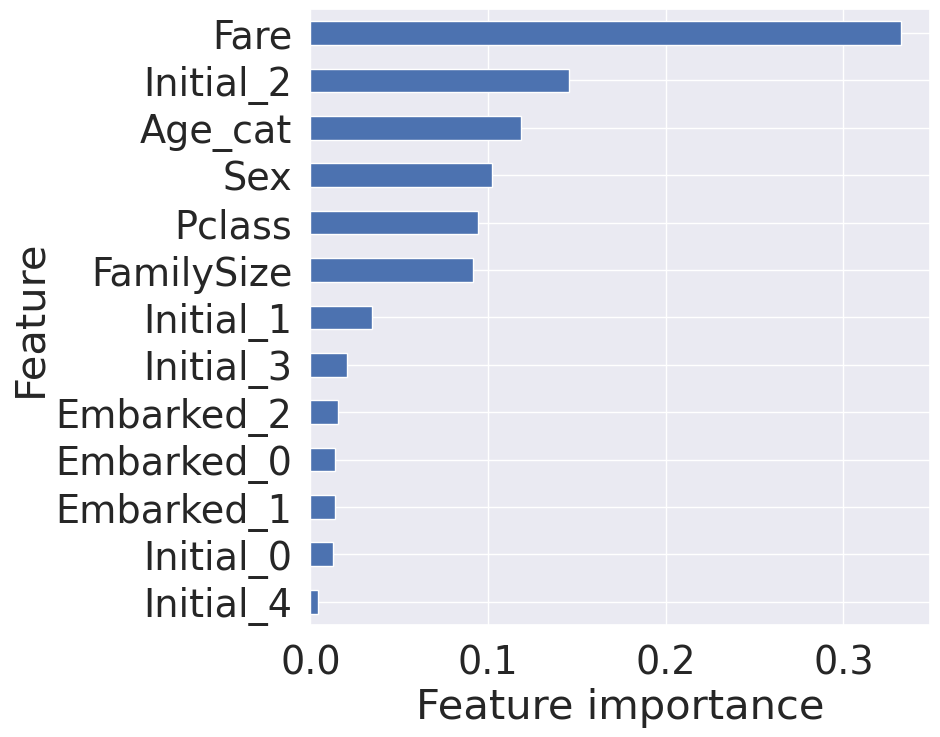

In [170]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [171]:
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [172]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [173]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [174]:
submission.to_csv('.\3team_submission.csv', index=False)